In [24]:
import pymc as pm
print(pm.__version__)


5.13.0


In [1]:
%matplotlib inline
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_99930/2919511161.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_99930/2919511161.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])


#### Code 6.1

In [6]:
n = 200

p = 0.1

nw = np.random.normal(50, 20, n)
sw = np.random.normal(50, 20, n)
s = nw + sw
q = np.quantile(s, 1-p)

df = pd.DataFrame({'nw':nw, 'sw':sw, 's':s})

df['selected'] = np.where(df.s >= q, 1, 0)
df[['nw', 'sw']][df['selected'] > 0].corr()

,nw,sw
nw,1.000000,-0.726512
sw,-0.726512,1.000000


#### Code 6.2

In [15]:
n = 100

height = np.random.normal(loc = 10, scale = 2, size =n)
leg_prop = np.random.uniform(low = .4, high = .5, size = n)

leg_left = leg_prop * height + np.random.normal(0, .02, n)
leg_right = leg_prop * height + np.random.normal(0, .02, n)

d = pd.DataFrame({
                'height': height,
                'leg_left': leg_left,
                'leg_right': leg_right,
                'proportion': leg_left / height
                })

display(d)

,height,leg_left,leg_right,proportion
0,12.822978,6.181315,6.213532,0.482050
1,7.978613,3.205172,3.222612,0.401720
2,11.397173,5.081350,5.079346,0.445843
3,13.163356,6.352994,6.327856,0.482627
4,7.788426,3.746432,3.749896,0.481026
...,...,...,...,...
95,11.753831,4.893847,4.902314,0.416362
96,8.440718,4.064785,4.069698,0.481569
97,9.732856,4.477551,4.415366,0.460045
98,6.957537,3.136607,3.159670,0.450821


#### Code 6.3

In [28]:

np.random.seed(909)

# Generate data
n = 100
height = np.random.normal(loc=10, scale=2, size=n)
leg_prop = np.random.uniform(low=0.4, high=0.5, size=n)
leg_left = leg_prop * height + np.random.normal(0, 0.02, n)
leg_right = leg_prop * height + np.random.normal(0, 0.02, n)

# Create DataFrame
d = pd.DataFrame({
    'height': height,
    'leg_left': leg_left,
    'leg_right': leg_right
})

# Define the model
with pm.Model() as m6_1:
    # Priors adjusted to match R
    alpha = pm.Normal('alpha', mu=10, sigma=100)
    bl = pm.Normal('bl', mu=2, sigma=10)
    br = pm.Normal('br', mu=2, sigma=10)

    # Linear model
    mu = pm.Deterministic('mu', alpha + bl * d['leg_left'] + br * d['leg_right'])
    sigma = pm.Exponential('sigma', 1)

    # Likelihood
    height_obs = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'])

    # Increased sampling for convergence
    trace = pm.sample(500)

    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bl, br, sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 29 seconds.


,chain,draw,bl,br
1332,2,332,0.847965,1.211065
601,1,101,-0.249588,2.356256
847,1,347,-1.800350,3.855302
1313,2,313,-0.159349,2.258169
1193,2,193,-2.127040,4.115837
756,1,256,-1.079323,3.068182
834,1,334,2.576521,-0.528168
1840,3,340,-3.252427,5.288592
951,1,451,-4.218860,6.116753
282,0,282,-1.298406,3.250602


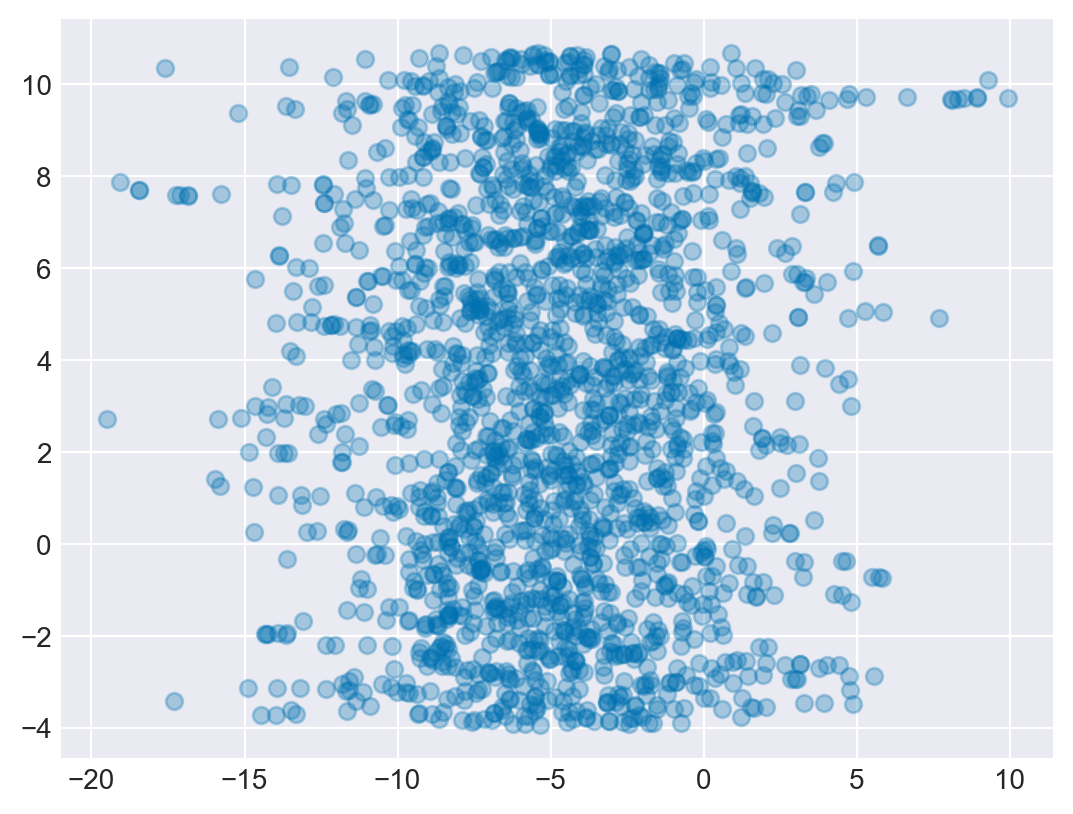

In [34]:
trace_df = trace.posterior[['bl','br']].to_dataframe().reset_index()

display(trace_df.sample(10))

post = np.linspace(trace_df.br.min(), trace_df.br.max(), trace_df.shape[0])

plt.scatter(trace_df.bl - trace_df.br, post, alpha = .3)

#### Code 6.6

<AxesSubplot: >

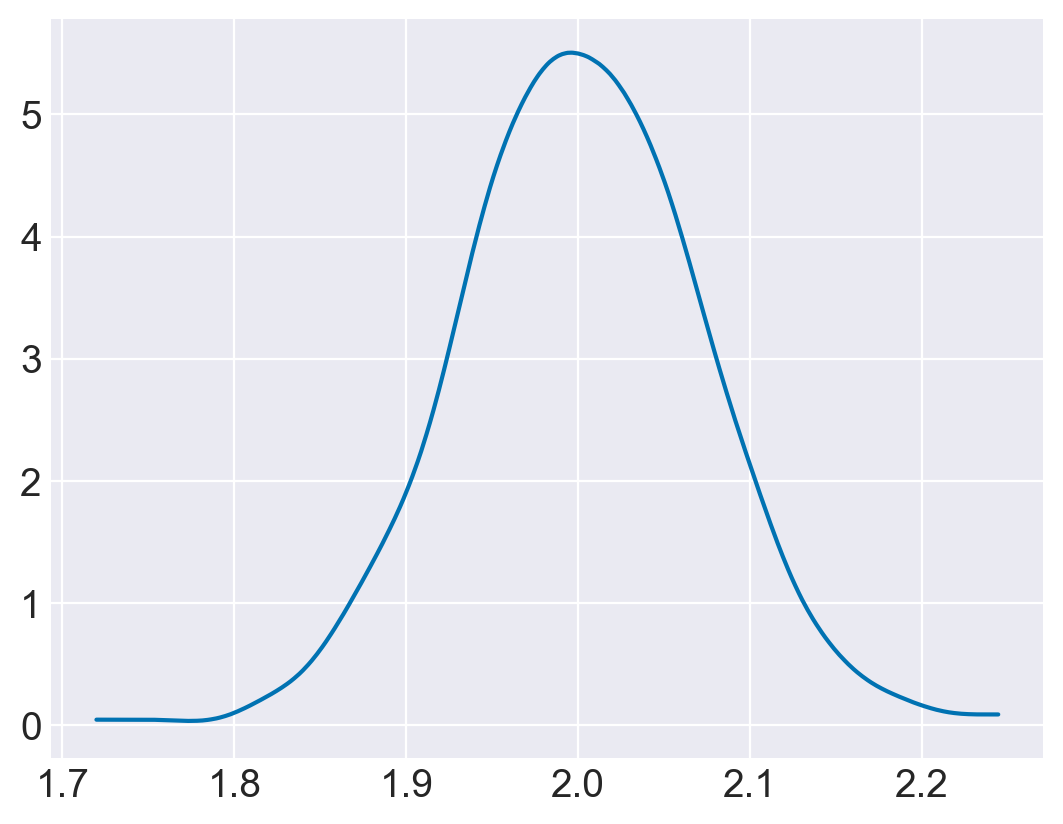

In [36]:
az.plot_kde(trace_df.bl + trace_df.br)

#### Code 6.7

In [40]:
with pm.Model() as m6_2:
    
    a = pm.Normal('a', mu = 10, sigma = 100)
    bl = pm.Normal('bl', 2, 10)
    mu = pm.Deterministic('mu', a + bl * d.leg_left)
    sigma = pm.Exponential('sigma', 1)
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.height)

    trace_2 = pm.sample()

pm.summary(trace_2, var_names = ['a', 'bl', 'sigma'], hdi_prob = .89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.819,0.337,0.274,1.356,0.010,0.007,1240.0,1201.0,1.0
bl,2.025,0.072,1.904,2.134,0.002,0.001,1247.0,1163.0,1.0
sigma,0.668,0.050,0.587,0.745,0.001,0.001,1997.0,1704.0,1.0


#### Code 6.8

In [ ]:
from scipy.stats import zscore

d = pd.read_csv('Data/milk.csv', sep = ';')

d['K'] = zscore(d['kcal.per.g'])
d['F'] = zscore(d['perc.fat'])
d['L'] = zscore(d['perc.lactose'])


#### Code 6.9

In [44]:
with pm.Model() as m6_3:
    
    a = pm.Normal('a', mu = 0, sigma = .2)
    bF = pm.Normal('bF', 0, .5)
    mu = pm.Deterministic('mu', a + bF * d.F)
    sigma = pm.Exponential('sigma', 1)
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.K)

    trace_2 = pm.sample()

display(pm.summary(trace_2, var_names = ['a', 'bF', 'sigma']))

with pm.Model() as m6_4:
    
    a = pm.Normal('a', mu = 0, sigma = .2)
    bL = pm.Normal('bL', 0, .5)
    mu = pm.Deterministic('mu', a + bL * d.L)
    sigma = pm.Exponential('sigma', 1)
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.K)

    trace_3 = pm.sample()

display(pm.summary(trace_3, var_names = ['a', 'bL', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.083,-0.156,0.154,0.001,0.001,5183.0,3159.0,1.0
bF,0.857,0.088,0.696,1.025,0.001,0.001,5224.0,3092.0,1.0
sigma,0.494,0.069,0.372,0.620,0.001,0.001,4624.0,2749.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bL, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.071,-0.128,0.137,0.001,0.001,5503.0,2651.0,1.0
bL,-0.901,0.077,-1.039,-0.754,0.001,0.001,4566.0,3107.0,1.0
sigma,0.419,0.061,0.312,0.536,0.001,0.001,4700.0,2769.0,1.0


#### Code 6.10

In [46]:
with pm.Model() as m6_5:
    
    a = pm.Normal('a', mu = 0, sigma = .2)
    bL = pm.Normal('bL', 0, .5)
    bF = pm.Normal('bF', 0, .5)
    mu = pm.Deterministic('mu', a + bL * d.L + bF * d.F)
    sigma = pm.Exponential('sigma', 1)
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.K)

    trace_5 = pm.sample()

display(pm.summary(trace_5, var_names = ['a', 'bL',  'bF', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bL, bF, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.072,-0.135,0.132,0.001,0.001,2689.0,2738.0,1.0
bL,-0.667,0.193,-1.045,-0.325,0.005,0.003,1597.0,2193.0,1.0
bF,0.253,0.193,-0.140,0.583,0.005,0.003,1705.0,2178.0,1.0
sigma,0.421,0.061,0.320,0.537,0.001,0.001,2792.0,2342.0,1.0


#### Code 6.11

/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_99930/2336317965.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix(


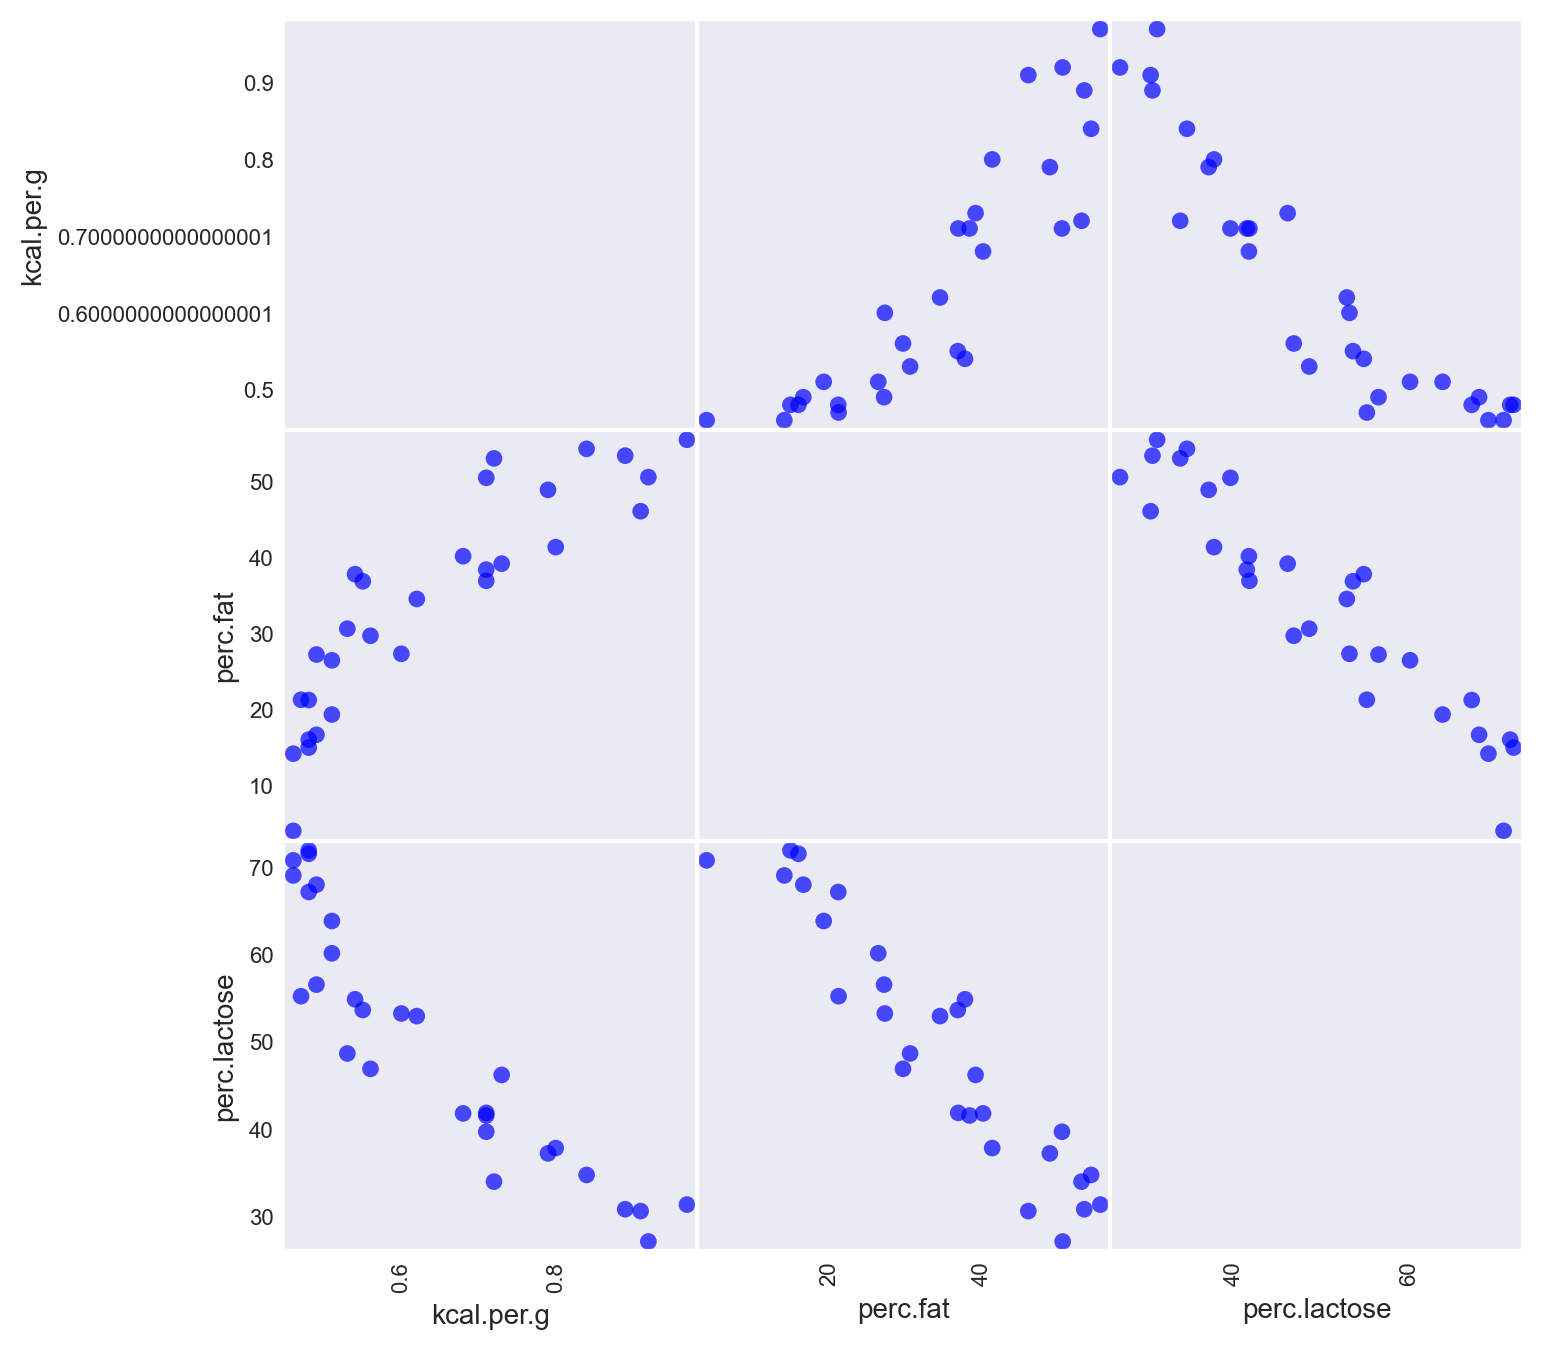

In [51]:
from pandas.plotting import scatter_matrix

# Create scatterplot matrix
fig, axes = plt.subplots(figsize=(8, 8))  # Set the overall figure size
scatter_matrix(
    d[['kcal.per.g', 'perc.fat', 'perc.lactose']],
    alpha=0.7,
    figsize=(8, 8),
    diagonal='label',
    marker='0',
    color='blue',
    ax=axes,
)

# Remove gridlines and improve outlines
for ax in plt.gcf().axes:
    ax.grid(False)  # Disable grid lines
    for spine in ax.spines.values():  # Thicken the outlines
        spine.set_linewidth(1.5)

# Show the plot
plt.show()

#### Code 6.12 (Overthinking)

In [ ]:
milk = pd.read_csv('Data/milk.csv', sep = ';')

def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    x = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.ols('kcal.per.g ~ perc.fat + x', data=milk).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 6.13

In [86]:
'''set.seed(71)
# number of plants
N <- 100
# simulate initial heights
h0 <- rnorm(N,10,2)
# assign treatments and simulate fungus and growth
treatment <- rep( 0:1 , each=N/2 )
fungus <- rbinom( N , size=1 , prob=0.5 - treatment*0.4 )
h1 <- h0 + rnorm(N, 5 - 3*fungus)
# compose a clean data frame
d <- data.frame( h0=h0 , h1=h1 , treatment=treatment , fungus=fungus )
precis(d)
'''
np.random.seed(71)

n = 100

h_0 = np.random.normal(10, 2, n)

treatment = np.repeat([0,1], n // 2)

fungus = np.random.binomial(size = n, n = 1, p = .5 - (treatment * .4))

h_1 = h_0 + np.random.normal(size = n, loc = 5 - 3*fungus)

d = pd.DataFrame({
                'h_0': h_0,
                'treatment': treatment,
                'fungus': fungus,
                'h_1': h_1
                })

d.describe(percentiles = [.055, .945]).T

,count,mean,std,min,5.5%,50%,94.5%,max
h_0,100.0,10.151728,1.667146,6.087715,7.425372,10.117129,12.427029,13.885944
treatment,100.0,0.500000,0.502519,0.000000,0.000000,0.500000,1.000000,1.000000
fungus,100.0,0.280000,0.451261,0.000000,0.000000,0.000000,1.000000,1.000000
h_1,100.0,14.492661,2.452841,7.294385,10.290879,14.733176,18.215741,20.043991


#### Code 6.14

In [103]:
d['sim_p'] = np.random.lognormal(size = 100, mean = 0, sigma = .25)

d.describe().T


,count,mean,std,min,25%,50%,75%,max
h_0,100.0,10.151728,1.667146,6.087715,9.045405,10.117129,11.368423,13.885944
treatment,100.0,0.500000,0.502519,0.000000,0.000000,0.500000,1.000000,1.000000
fungus,100.0,0.280000,0.451261,0.000000,0.000000,0.000000,1.000000,1.000000
h_1,100.0,14.492661,2.452841,7.294385,12.737115,14.733176,16.260289,20.043991
sim_p,100.0,1.028455,0.295412,0.492499,0.821768,1.037323,1.176865,2.277723


#### Code 6.15

In [108]:
d.dtypes

h_0          float64
treatment      int64
fungus         int64
h_1          float64
sim_p        float64
dtype: object

In [112]:
with pm.Model() as m6_6:
    p = pm.LogNormal('p', mu = 0, sigma = .25)
    mu = pm.Deterministic('mu', d.h_0.values * p)
    sigma = pm.Exponential('sigma', 1)

    likelihood = pm.Normal('lh', mu = mu, sigma = sigma, observed = d.h_1)

    trace_6 = pm.sample()

pm.summary(trace_6, var_names = ['p', 'sigma'] ,hdi_prob = .89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.415,0.018,1.389,1.448,0.000,0.000,4060.0,3055.0,1.0
sigma,1.888,0.134,1.686,2.113,0.002,0.001,4089.0,2944.0,1.0


#### Code 6.16

In [114]:
with pm.Model() as m6_7:
    a = pm.LogNormal('a', mu = 0, sigma = .25)
    bT = pm.Normal('bT', mu = 0, sigma = .5)
    bF = pm.Normal('bF', mu = 0, sigma = .5)
    p = pm.Deterministic('p', a + bT * d.treatment + bF * d.fungus)
    mu = pm.Deterministic('mu', d.h_0.values * p)
    sigma = pm.Exponential('sigma', 1)

    likelihood = pm.Normal('lh', mu = mu, sigma = sigma, observed = d.h_1)

    trace_7 = pm.sample()

pm.summary(trace_7, var_names = ['a', 'bT', 'bF', 'sigma'] ,hdi_prob = .89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bT, bF, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.515,0.022,1.478,1.548,0.001,0.000,1763.0,2177.0,1.0
bT,-0.020,0.027,-0.065,0.020,0.001,0.000,1782.0,2314.0,1.0
bF,-0.314,0.030,-0.364,-0.271,0.001,0.000,2568.0,2898.0,1.0
sigma,1.253,0.089,1.109,1.388,0.002,0.001,2988.0,2184.0,1.0


#### Code 6.17

In [ ]:
with pm.Model() as m6_8:
    a = pm.LogNormal('a', mu = 0, sigma = .25)
    bT = pm.Normal('bT', mu = 0, sigma = .5)
    p = pm.Deterministic('p', a + bT * d.treatment )
    mu = pm.Deterministic('mu', d.h_0.values * p)
    sigma = pm.Exponential('sigma', 1)

    likelihood = pm.Normal('lh', mu = mu, sigma = sigma, observed = d.h_1)

    trace_8 = pm.sample()

pm.summary(trace_8, var_names = ['a', 'bT', 'sigma'] ,hdi_prob = .89)

#### Code 6.18

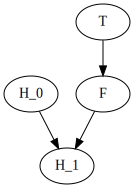

[('H_0', 'T', set()),
 ('H_0', 'T', {'F'}),
 ('H_0', 'T', {'F', 'H_1'}),
 ('H_0', 'F', set()),
 ('H_0', 'F', {'T'}),
 ('T', 'H_1', {'F'}),
 ('T', 'H_1', {'F', 'H_0'})]

In [134]:
from causalgraphicalmodels import CausalGraphicalModel

model = CausalGraphicalModel(
    nodes = ['H_0','H_1', 'F', 'T'],
    edges = (['H_0','H_1'], ['F','H_1'], ['T','F'])
)

display(model.draw())


#### Code 6.19

In [135]:
model.get_all_independence_relationships()

[('H_0', 'T', set()),
 ('H_0', 'T', {'F'}),
 ('H_0', 'T', {'F', 'H_1'}),
 ('H_0', 'F', set()),
 ('H_0', 'F', {'T'}),
 ('T', 'H_1', {'F'}),
 ('T', 'H_1', {'F', 'H_0'})]

#### Code 6.20

In [149]:
n = 1000

h_0 = np.random.normal(10,2,n)

treatment = np.repeat([0,1], n/2)

m = np.random.binomial(1, .5, n)

fungus = np.random.binomial(1, .5 - treatment * .4 + .4 * m, n)

h_1 = h_0 + np.random.normal(5 + 3 * m, size = n)

d2 = pd.DataFrame({'h_0': h_0,
                  'treatment': treatment,
                  'm': m,
                  'fungus': fungus,
                  'h_1': h_1})

d2.sample(15)

,h_0,treatment,m,fungus,h_1
710,8.624769,1,0,0,12.166034
714,9.320044,1,1,0,19.190770
18,6.875905,0,1,1,13.595270
970,8.745036,1,1,0,17.241927
51,8.111049,0,0,1,13.759958
426,12.739669,0,1,0,20.219342
498,6.783770,0,0,1,12.460044
920,7.275124,1,0,0,12.369556
90,11.324697,0,1,1,19.051092
270,12.792366,0,0,1,17.471898


#### Code 6.21

,age,married,happiness
969,17,0,-0.105263
955,18,0,1.157895
741,28,0,-1.789474
95,61,1,1.157895
94,61,1,0.947368
1018,15,0,1.789474
1253,3,0,0.736842
859,23,0,2.000000
993,16,0,0.736842
927,19,0,-0.526316


,count,mean,std,min,25%,50%,75%,max
age,1300.0,3.300000e+01,18.768883,1.0,17.0,3.300000e+01,49.0,65.0
married,1300.0,2.915385e-01,0.454646,0.0,0.0,0.000000e+00,1.0,1.0
happiness,1300.0,-8.335213e-17,1.214421,-2.0,-1.0,-1.110223e-16,1.0,2.0


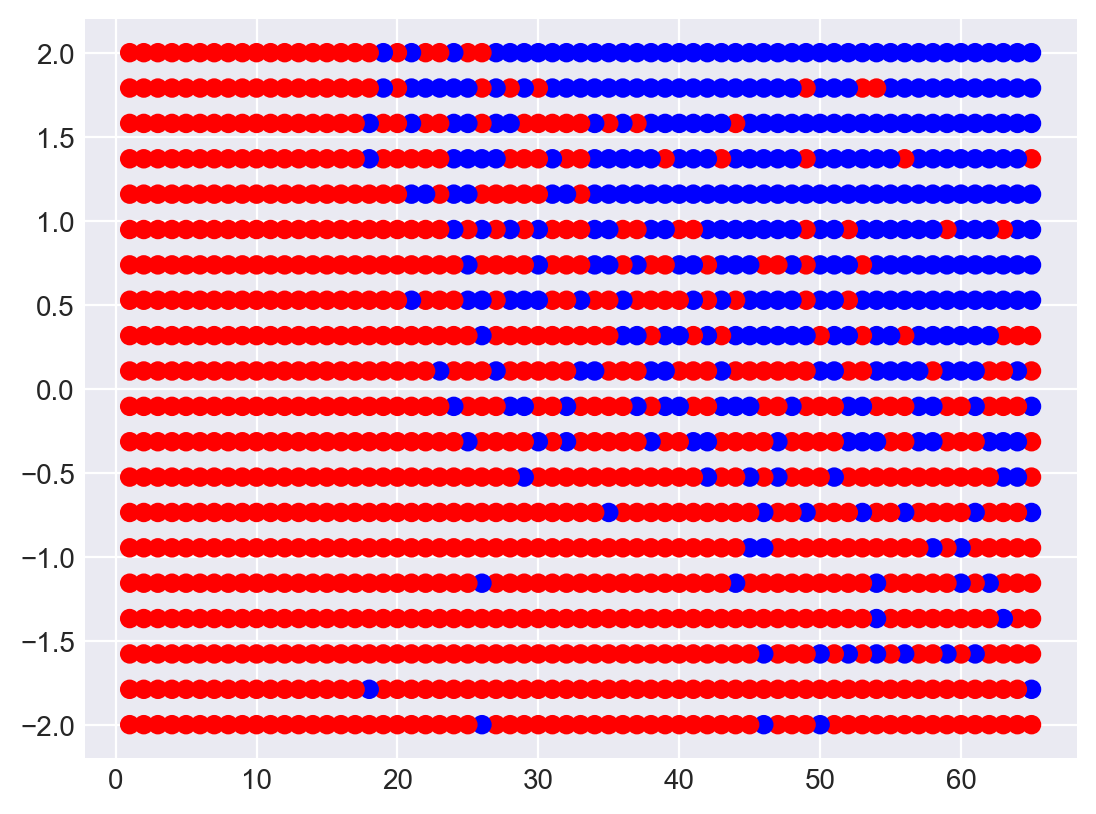

In [176]:
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    np.random.seed(seed)

    H, M, A = [], [], []

    for t in range(N_years):
        # Age existing individuals
        A = [age + 1 for age in A]
        # Add newborns
        A.extend([1] * N_births)

        # Simulate happiness trait for newborns
        H.extend(np.linspace(-2, 2, N_births))

        # Mark newborns as not married
        M.extend([0] * N_births)

        # Check marriage eligibility
        for i in range(len(A)):
            if A[i] >= aom and M[i] == 0:
                M[i] = np.random.binomial(1, 1 / (1 + np.exp(-(H[i] - 4))))

        # Handle mortality
        deaths = [i for i, age in enumerate(A) if age > max_age]
        for i in sorted(deaths, reverse=True):
            del A[i]
            del H[i]
            del M[i]

    # Create a DataFrame
    d = pd.DataFrame({'age': A, 'married': M, 'happiness': H})
    return d

marriage_data = sim_happiness()

display(marriage_data.describe().T)


#### Code 6.22

In [208]:
d = marriage_data[marriage_data.age > 17]

d['A']= (d.age - 18) / (65 -18)

/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_99930/3357396848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['A']= (d.age - 18) / (65 -18)


#### Code 6.23

In [214]:
with pm.Model() as m6_9:
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', mu = 0, sigma = 2)
    a = pm.Normal('a', mu = 0, sigma = 1, shape = 2)
    mu = pm.Deterministic('mu', a[d.married] + bA * d.A)

    y = pm.Normal('y', mu = mu, sigma= sigma, observed = d.happiness)

    trace_9 = pm.sample()
    display(pm.summary(trace_9, hdi_prob = .89, var_names = ['bA', 'a', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.708,0.111,-0.881,-0.527,0.002,0.002,2000.0,2597.0,1.0
a[0],-0.248,0.062,-0.347,-0.150,0.001,0.001,2210.0,2674.0,1.0
a[1],1.272,0.083,1.142,1.404,0.002,0.001,2165.0,2658.0,1.0
sigma,0.984,0.023,0.946,1.019,0.000,0.000,2645.0,2223.0,1.0


#### Code 6.24

In [215]:
with pm.Model() as m6_10:
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', mu = 0, sigma = 2)
    a = pm.Normal('a', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', a + bA * d.A)

    y = pm.Normal('y', mu = mu, sigma= sigma, observed = d.happiness)

    trace_10 = pm.sample()
    display(pm.summary(trace_10, hdi_prob = .89, var_names = ['bA', 'a', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,0.002,0.135,-0.217,0.216,0.003,0.002,2048.0,2242.0,1.0
a,-0.001,0.079,-0.125,0.127,0.002,0.001,1989.0,2146.0,1.0
sigma,1.217,0.028,1.171,1.259,0.001,0.000,2339.0,2076.0,1.0


#### Figure 6.4

Text(0.5, 1.0, 'Unmarried vs Married individuals')

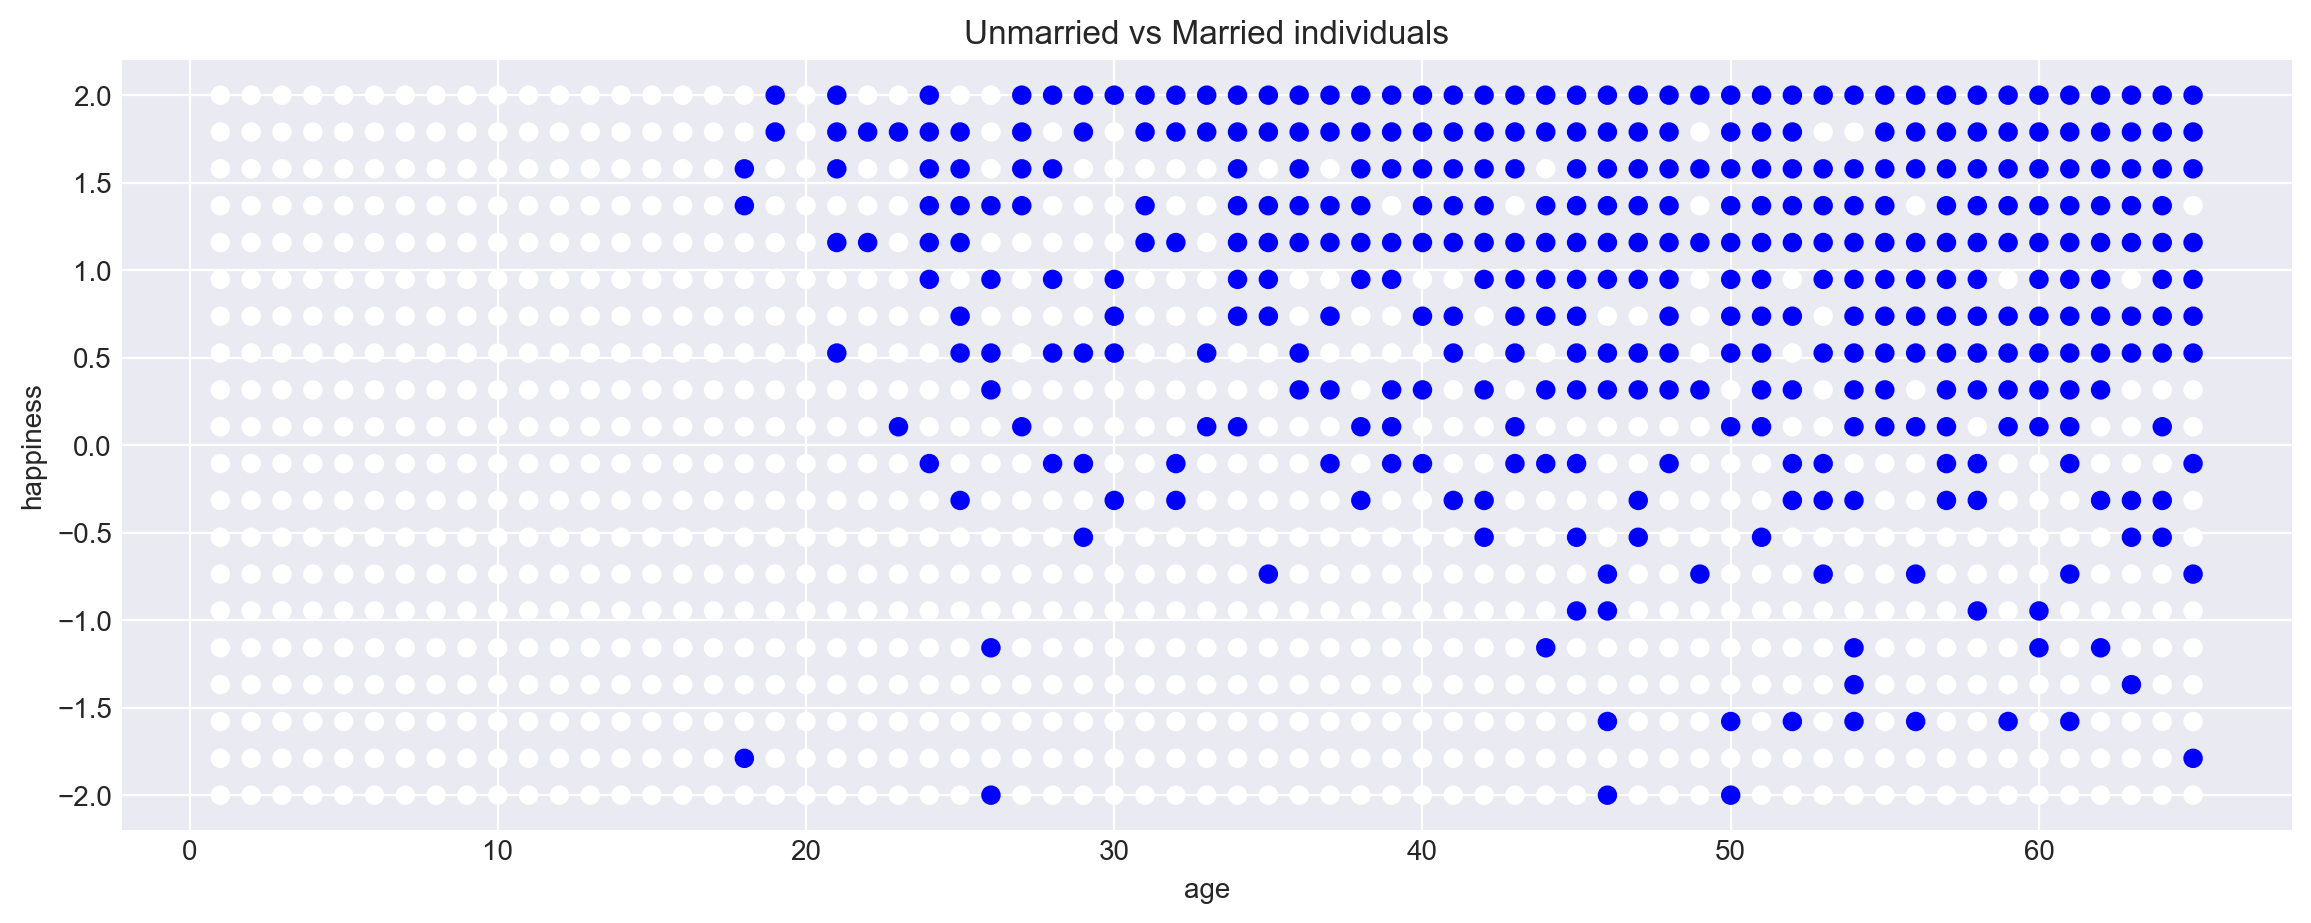

In [198]:
filled = marriage_data['married'].map({1: 'blue', 0: 'white'})

plt.figure(figsize= (14,5));
plt.scatter(marriage_data.age, marriage_data.happiness, facecolors = filled, label = "married");
plt.xlabel('age');
plt.ylabel('happiness');
plt.title('Unmarried vs Married Individuals');

#### Code 6.25

In [242]:
N = 200

b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

#### Code 6.26

In [243]:
np.random.seed(21)

U = 2 * np.random.binomial(1, .5, N) - 1
G = np.random.normal(size = N)
P = np.random.normal(b_GP*G + b_U*U, size = N)
C = np.random.normal(b_PC*P + b_GC*G + b_U*U, size = N)

d = pd.DataFrame({'U': U, 'G': G, 'P': P, 'C': C})

display(d)

,U,G,P,C
0,-1,1.516635,-1.971917,-5.566973
1,-1,-1.660613,-4.476302,-6.656230
2,1,-1.155654,-0.575301,-0.076296
3,-1,-0.224142,-0.861204,-3.123987
4,-1,-0.383867,-3.468551,-6.324834
...,...,...,...,...
195,1,-0.381640,-0.892301,1.774742
196,1,-1.223696,-0.777930,1.523887
197,1,1.346038,3.357203,5.314495
198,-1,-1.003804,-3.835850,-5.822431


#### Code 6.27

In [244]:
with pm.Model() as m6_11:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0 , 1)
    b_PC = pm.Normal('b_PC', 0, 1)
    b_GC = pm.Normal('b_GC', 0, 1)
    mu = pm.Deterministic('mu', a + b_PC * d.P + b_GC * d.G)

    y = pm.Normal('y', mu = mu, sigma = sigma, observed = d.C)

    trace_11 = pm.sample()
    display(pm.summary(trace_11, hdi_prob = .89, var_names = ['b_PC', 'b_GC', 'a', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, b_PC, b_GC]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_PC,1.787,0.040,1.722,1.851,0.001,0.000,5159.0,3437.0,1.0
b_GC,-0.692,0.100,-0.859,-0.539,0.001,0.001,4778.0,3056.0,1.0
a,-0.144,0.093,-0.297,0.001,0.001,0.001,5967.0,3350.0,1.0
sigma,1.312,0.065,1.210,1.408,0.001,0.001,5734.0,2983.0,1.0


#### Code 6.28

In [245]:
with pm.Model() as m6_12:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0 , 1)
    b_PC = pm.Normal('b_PC', 0, 1)
    b_GC = pm.Normal('b_GC', 0, 1)
    b_U = pm.Normal('b_U', 0, 1)
    mu = pm.Deterministic('mu', a + b_PC * d.P + b_GC * d.G + b_U * d.U)

    y = pm.Normal('y', mu = mu, sigma = sigma, observed = d.C)

    trace_12 = pm.sample()
    display(pm.summary(trace_12, hdi_prob = .89, var_names = ['b_PC', 'b_GC', 'b_U', 'a', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, b_PC, b_GC, b_U]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_PC,1.061,0.072,0.942,1.171,0.002,0.001,1633.0,2192.0,1.0
b_GC,0.014,0.100,-0.141,0.174,0.002,0.002,1996.0,2310.0,1.0
b_U,1.884,0.169,1.611,2.153,0.004,0.003,1700.0,2269.0,1.0
a,-0.135,0.071,-0.248,-0.022,0.001,0.001,3870.0,2729.0,1.0
sigma,1.015,0.052,0.930,1.095,0.001,0.001,3186.0,2538.0,1.0


#### Code 6.29

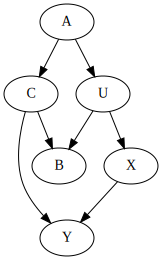

Valid adjustment sets without unobserved nodes (U):
{'C'}
{'C', 'A', 'B'}
{'C', 'B'}
{'A'}
{'C', 'A'}


In [255]:
# Define the causal model
model = CausalGraphicalModel(
    nodes=["A", "B", "C", "X", "Y", "U"],  # U is unobserved
    edges=[
        ("U", "X"),
        ("X", "Y"),
        ("A", "U"),
        ("U", "B"),
        ("A", "C"),
        ("C", "B"),
        ("C", "Y")
    ]
)

# Visualize the graph
display(model.draw())

# Get all backdoor adjustment sets for X → Y
adjustment_sets = model.get_all_backdoor_adjustment_sets('X', 'Y')

# Exclude sets containing U (unobserved)
observed_adjustment_sets = [s for s in adjustment_sets if 'U' not in s]

# Print valid adjustment sets
print("Valid adjustment sets without unobserved nodes (U):")
for s in observed_adjustment_sets:
    print(set(s))


#### Code 6.30

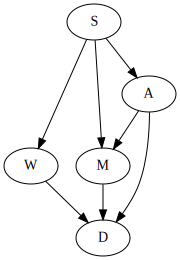

[('W', 'A', {'S'}),
 ('W', 'A', {'M', 'S'}),
 ('W', 'M', {'S'}),
 ('W', 'M', {'A', 'S'}),
 ('S', 'D', {'A', 'M', 'W'})]

In [264]:
# Define the causal model
model = CausalGraphicalModel(
    nodes=["A", "D", "M", "S", "W", "D"],  # U is unobserved
    edges=[
        ("S", "W"),
        ("S", "A"),
        ("S", "M"),
        ("A", "D"),
        ("A", "M"),
        ("M", "D"),
        ("W", "D"),
    ]
)

# Visualize the graph
display(model.draw())
model.get_all_independence_relationships()

---
#### C3E1

**Question**: 

Modify the DAG on page 190 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. 

(1) How many paths connect X to Y? 

(2) Which must be closed?

(3) Which variables should you condition on now?

---
<details>
<summary>Answer</summary>

(1)

- X -> Y
- X <- U <- A -> C -> Y
- X <- U <- A -> C -> <- V -> Y
- X <- U -> B <- C -> Y
- X <- U -> B <- C -> <- V -> Y

There are 5 total paths

(2)

Everything but X-> and X <- U <- A -> C -> Y need to be closed.

(3)

Considering those two paths the only varialbe that needs to be closed is A. It will close all the backdoor paths as efficiently as possible. Because V is downstream of A, it doesn't add any new blocking power once A is conditioned on.


</details>

---
#### C3H1

**Question**: 

Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

---
<details>
<summary>Answer</summary>



</details>

In [267]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

d

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


---
#### C3E1

**Question**: 

Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

---
<details>
<summary>Answer</summary>



</details>